<h1>Build feature and output arrays

In [111]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder

synthetic = True # set to True to include synthetic data

# lists for all data
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

# load JSON-file
with open(f"data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# collect data
for wpp in WPP_production_wind:
    all_turbine_types.append(wpp["Turbine"])
    all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(wpp["Commission_date"] if wpp["Commission_date"] != "nan" else "2015/06")
    all_production_data.append(wpp["Production"])

if synthetic:
    with open(f"data/synthetic_data.json", "r", encoding="utf-8") as file:
        WPP_production_wind_synthetic = json.load(file)

    # collect data
    for wpp in WPP_production_wind_synthetic:
        all_turbine_types.append(wpp["Turbine"])
        all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
        all_capacities.append(wpp["Capacity"])
        all_commissioning_dates.append(wpp["Commissioning_date"] if wpp["Commissioning_date"] != "nan" else "2015/06")
        all_production_data.append(wpp["Production"])

# One-Hot-Encoding for turbine types
encoder = OneHotEncoder(sparse_output=False)
turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

# correct data format for commissioning dates
all_commissioning_dates = [
    "2015/06" if date == "nan" else f"{date}/06" if isinstance(date, str) and "/" not in date else date
    for date in all_commissioning_dates
]

# convert to datetime
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# calculate age
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# create combined features and output lists
combined_features_raw = []
output_raw = []

# convert data in feature arrays
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # repetitions for common features
    turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # extract production values and wind speeds
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1)
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    # combine all features
    combined_chunk = np.hstack((
        turbine_type_repeated,
        hub_height_repeated,
        capacity_repeated,
        age_repeated,
        wind_speeds
    ))

    # add the data
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

np.save("turbine_types_order.npy", encoder.categories_[0])

# combine all data chunks to one array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)

# round all values to two decimal places
combined_features_raw = np.round(combined_features_raw, decimals=2)
output_raw = np.round(output_raw, decimals=2)

C:\Users\alexa\AppData\Local\Temp\ipykernel_33260\2998175039.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=False, patch_artist=True, labels=["Training Data", "All Data"])


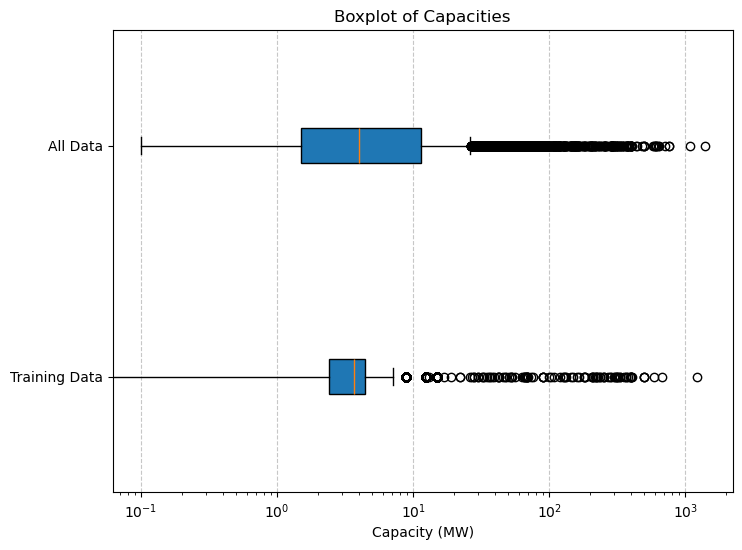

In [112]:
import matplotlib.pyplot as plt

df = pd.read_parquet("data/WPPs/The_Wind_Power.parquet")
capacities_the_wind_power = df['Total power'].values / 1e3

data = [all_capacities, capacities_the_wind_power]

plt.figure(figsize=(8, 6))
plt.boxplot(data, vert=False, patch_artist=True, labels=["Training Data", "All Data"])
plt.title("Boxplot of Capacities")
plt.xlabel("Capacity (MW)")
plt.xscale("log")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [113]:
import numpy as np

# Erstelle eine Maske mit 10.000 zufälligen Indizes
random_indices = np.random.choice(combined_features_raw.shape[0], 10000, replace=False)

combined_features_subset = combined_features_raw.copy()
output_subset = output_raw.copy()

# Extrahiere die entsprechenden Werte aus den Arrays
combined_features_subset = combined_features_subset[random_indices]
output_subset = output_subset[random_indices]

<h1>Scale feature vector and define Dataset

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
import joblib

combined_features = combined_features_subset.copy()
output = output_subset.copy()

# Standardisierung der numerischen Features (individuell!)

# Separate Scaler für jedes Feature
scaler_wind = StandardScaler()
scaler_ages = StandardScaler()
scaler_capacities = StandardScaler()
scaler_hub_heights = StandardScaler()

# Skalieren der einzelnen Features
combined_features[:, -1] = scaler_wind.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
combined_features[:, -2] = scaler_ages.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten()  # scale ages
combined_features[:, -3] = scaler_capacities.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten()  # scale capacities
combined_features[:, -4] = scaler_hub_heights.fit_transform(combined_features[:, -4].reshape(-1, 1)).flatten()  # scale hub heights

# Speichere alle Scaler in einem Dictionary
scalers = {
    "winds": scaler_wind,
    "ages": scaler_ages,
    "capacities": scaler_capacities,
    "hub_heights": scaler_hub_heights,
}

# Speichere das Dictionary mit Joblib
joblib.dump(scalers, "scalers.pkl")

# Trainings- und Testaufteilung
train_features, test_features, train_targets, test_targets = train_test_split(combined_features, output, test_size=0.2, shuffle=True)

# Dataset-Klasse für PyTorch
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Erstellung der PyTorch-Datasets
train_val_dataset = WindPowerDataset(train_features, train_targets)
test_dataset = WindPowerDataset(test_features, test_targets)

# Ausgabe der Formen
print("Train and Validation Features Shape:", train_features.shape)
print("Train and Validation Targets Shape:", train_targets.shape)
print("Test Features Shape:", test_features.shape)
print("Test Targets Shape:", test_targets.shape)

Train and Validation Features Shape: (8000, 50)
Train and Validation Targets Shape: (8000, 1)
Test Features Shape: (2000, 50)
Test Targets Shape: (2000, 1)


<h1>Define Model

In [7]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # define layers as nn.Sequential, for better visualisability in TensorBoard and compatibility with DeepExplainer from SHAP
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# class MLP(nn.Module):
#     def __init__(self, input_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 32)
#         self.fc5 = nn.Linear(32, 1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.relu(self.fc4(x))
#         x = self.fc5(x)  # No activation in the output layer for regression
#         return x

In [115]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, use_dropout=False, dropout_rate=0.3, 
                 use_batch_norm=False, activation_fn=nn.ReLU):
        super(MLP, self).__init__()

        layers = []

        # Erste Schicht
        layers.append(nn.Linear(input_size, 256))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(256))
        layers.append(activation_fn())

        # Zweite Schicht
        layers.append(nn.Linear(256, 128))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(128))
        layers.append(activation_fn())

        # Dritte Schicht
        layers.append(nn.Linear(128, 64))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(64))
        layers.append(activation_fn())

        # Vierte Schicht
        layers.append(nn.Linear(64, 32))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(32))
        layers.append(activation_fn())

        # Dropout nach der letzten versteckten Schicht (optional)
        if use_dropout:
            layers.append(nn.Dropout(dropout_rate))

        # Ausgabeschicht
        layers.append(nn.Linear(32, 1))

        # Modell zusammenstellen
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

<h1>1. Hyperparameter search: Training, Validation

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
import optuna
import time
import pynvml
import psutil

# Ressourcenüberwachung initialisieren
gpu_used = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    pynvml.nvmlInit()
    gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # GPU 0 verwenden

n_splits = 4  # Anzahl der Folds für Kreuzvalidierung

def system_info():
    print("PyTorch Version:", torch.__version__)
    print("CUDA Available:", torch.cuda.is_available())
    print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    if torch.cuda.is_available():
        print("\nCUDA Details:")
        print("CUDA Version:", torch.version.cuda)
        print("Number of GPUs:", torch.cuda.device_count())
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
            print(f"  - Compute Capability: {torch.cuda.get_device_capability(i)}")
            print(f"  - Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
            print(f"  - Memory Cached: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")

if __name__ == "__main__":
    system_info()

# Bewertungsfunktion
def objective(trial):
    original_batch_size = trial.suggest_int("batch_size", 16, 128)
    batch_size = int(2 ** round(np.log2(original_batch_size)))  # Transformierte Batch-Größe
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    number_epochs = trial.suggest_int("number_epochs", 10, 100)
    use_dropout = trial.suggest_categorical("use_dropout", [True, False])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    use_batch_norm = trial.suggest_categorical("use_batch_norm", [True, False])

    # Speichern der transformierten Batch-Größe als Attribut
    trial.set_user_attr("transformed_batch_size", batch_size)

    print(f"Evaluating: batch_size={batch_size}, lr={lr:.5f}, number_epochs={number_epochs}, "
          f"use_dropout={use_dropout}, dropout_rate={dropout_rate}, use_batch_norm={use_batch_norm}")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    len_train_val_dataset = len(train_val_dataset)

    input_size = train_features.shape[1]
    avg_val_loss = 0.0  # Durchschnittlicher Validierungsverlust
    start_time = time.time()  # Zeitmessung starten
    max_memory_usage = 0  # Maximale Speicher-Auslastung

    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len_train_val_dataset)), 1):
        print(f"  Fold {fold}/{kf.n_splits}")

        model = torch.jit.script(MLP(input_size=input_size, use_dropout=use_dropout, dropout_rate=dropout_rate, use_batch_norm=use_batch_norm)).to(device)

        train_fold_dataset = Subset(train_val_dataset, train_idx)
        val_fold_dataset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)

        criterion = nn.HuberLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(number_epochs):
            model.train()
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if device == torch.device("cuda"):
                    memory_info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
                    max_memory_usage = max(max_memory_usage, memory_info.used / 1024 ** 2)  # MB
                    global gpu_used
                    gpu_used = True
                else:
                    max_memory_usage = max(max_memory_usage, psutil.virtual_memory().used / 1024 ** 2)  # MB

        model.eval() # deactivates Batch normalisation and Dropout
        fold_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                val_outputs = model(batch_x)
                fold_val_loss += criterion(val_outputs, batch_y).item()
                
        avg_val_loss += fold_val_loss / len(val_loader)

    avg_val_loss /= kf.n_splits
    elapsed_time = time.time() - start_time

    weighted_score = 0.7 * avg_val_loss + 0.15 * elapsed_time + 0.15 * max_memory_usage

    trial.set_user_attr("resource_usage", max_memory_usage)
    trial.set_user_attr("elapsed_time", elapsed_time)
    trial.set_user_attr("avg_val_loss", avg_val_loss)
    trial.set_user_attr("weighted_score", weighted_score)

    return weighted_score

# Optuna-Optimierung starten
best_val_loss = float("inf")
best_params = None

study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\nBeste Parameterkombination:")
print(study.best_params)

# Ausgabe des besten Validierungsverlusts
best_trial = study.best_trial
print(f"Bester Validierungsverlust: {best_trial.user_attrs['avg_val_loss']}")

for trial in study.trials:
    print(trial)

# Debugging: Überprüfung, ob GPU verwendet wurde
if gpu_used:
    print("GPU wurde erfolgreich während des Trainings verwendet.")
else:
    print("GPU wurde nicht verwendet.")

[I 2024-12-29 10:34:14,941] A new study created in memory with name: no-name-525f1fc7-1deb-4bbb-9e18-351479e0a262


PyTorch Version: 2.5.1
CUDA Available: False
Device: cpu


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: batch_size=64, lr=0.00242, number_epochs=1, use_dropout=True, dropout_rate=0.32322596965577166, use_batch_norm=True
  Fold 1/4
    Epoch 1/1
15.04929367860272
  Fold 2/4
    Epoch 1/1
[W 2024-12-29 10:35:54,564] Trial 0 failed with parameters: {'batch_size': 56, 'lr': 0.0024180495694975583, 'number_epochs': 1, 'use_dropout': True, 'dropout_rate': 0.32322596965577166, 'use_batch_norm': True} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\alexa\AppData\Local\Temp\ipykernel_26132\1513485689.py", line 79, in objective
    for batch_x, batch_y in train_loader:
                            ^^^^^^^^^^^^
  File "c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\torch\utils\data\dataloader.py", line 697, in __next__
    wi

KeyboardInterrupt: 

<h1>2. With best hyperparameters: Training and Testing

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from torch.nn import HuberLoss, MSELoss, L1Loss

log_dir = "runs"

# TensorBoard-Prozess beenden
try:
    if platform.system() == "Windows":
        subprocess.run(["taskkill", "/IM", "tensorboard.exe", "/F"], check=True)
    else:
        subprocess.run(["pkill", "-f", "tensorboard"], check=True)
    print("Terminated TensorBoard process")
except subprocess.CalledProcessError:
    print("No TensorBoard process found or could not be terminated")

# Log-Verzeichnis löschen
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
os.makedirs(log_dir, exist_ok=True)

subprocess.Popen(["tensorboard", "--logdir=runs", "--bind_all"])
print("TensorBoard started.")

# TensorBoard-Writer starten
writer = SummaryWriter(f"{log_dir}/final_training")

# Daten splitten
train_x, test_x, train_y, test_y = train_test_split(train_features, train_targets, test_size=0.2, shuffle=True, random_state=42)

# Modell initialisieren
model = MLP(
    input_size=train_x.shape[1],
    use_dropout=best_params["use_dropout"],
    dropout_rate=best_params["dropout_rate"],
    use_batch_norm=best_params["use_batch_norm"]
).to(device)

# Visualisierung des Modells
example_input = torch.randn(best_params["batch_size"], train_x.shape[1]).to(device)
writer.add_graph(model, example_input)

# Trainings-Konfiguration
criterion = HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

# Daten-Loader
train_loader = DataLoader(list(zip(train_x, train_y)), batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(list(zip(test_x, test_y)), batch_size=best_params["batch_size"], shuffle=False)

# Training
num_epochs = best_params["number_epochs"]

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    writer.add_scalar("Training Loss", train_loss, epoch)

# Testen
model.eval()
mae_criterion = L1Loss()
mse_criterion = MSELoss()
huber_criterion = HuberLoss()

test_loss_mae, test_loss_mse, test_loss_huber = 0, 0, 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        preds = model(batch_x)
        
        test_loss_mae += mae_criterion(preds, batch_y).item()
        test_loss_mse += mse_criterion(preds, batch_y).item()
        test_loss_huber += huber_criterion(preds, batch_y).item()

test_loss_mae /= len(test_loader)
test_loss_mse /= len(test_loader)
test_loss_huber /= len(test_loader)

# Ergebnisse anzeigen
print(f"Endgültiger MAE: {test_loss_mae:.4f}")
print(f"Endgültiger MSE: {test_loss_mse:.4f}")
print(f"Endgültiger Huber Loss: {test_loss_huber:.4f}")

# TensorBoard-Writer schließen
writer.close()

<h1>3. With all data: Training for deployment

In [ ]:
# Modell initialisieren
model = MLP(
    input_size=train_features.shape[1],
    use_dropout=best_params["use_dropout"],
    dropout_rate=best_params["dropout_rate"],
    use_batch_norm=best_params["use_batch_norm"]
).to(device)

# Trainings-Konfiguration
criterion = HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

# Daten-Loader für alle Trainingsdaten
train_loader = DataLoader(list(zip(train_features, train_targets)), batch_size=best_params["batch_size"], shuffle=True)

# Training
num_epochs = best_params["number_epochs"]

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    writer.add_scalar("Final Training Loss", train_loss, epoch)

# Modell speichern
torch.save(model.state_dict(), "trained_model_for_deployment.pth")
print("Modell für Deployment gespeichert!")

old code for hyperparameter search

In [116]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import shutil
import os
import subprocess
from torch.utils.tensorboard import SummaryWriter
import platform

# Hyperparameter-Raum definieren
# param_space = {
#     "hidden_size": [32, 64, 128, 256],
#     "batch_size": [16, 32, 64],
#     "lr": [1e-2, 1e-3, 1e-4],
#     "number_epochs": [20, 50, 100],
# }
param_space = {
    "hidden_size": [32],
    "batch_size": [32],
    "lr": [1e-3],
    "number_epochs": [20],
    "n_splits": [2]
}

# Funktion zur Auswahl eines zufälligen Parametersets
def random_search(param_space, n_trials):
    trials = []
    for _ in range(n_trials):
        trial = {key: random.choice(values) for key, values in param_space.items()}
        trials.append(trial)
    return trials

# Generiere zufällige Parameterkombinationen
n_trials = 1
params = random_search(param_space, n_trials)[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# KFold-Objekt
kf = KFold(n_splits=params["n_splits"], shuffle=True, random_state=42)
len_train_val_dataset = len(train_val_dataset)

# Ergebnis-Tracking
best_val_loss = float("inf")
best_params = None
results = []

input_size = train_features.shape[1]

# TensorBoard-Prozess beenden
try:
    if platform.system() == "Windows":
        subprocess.run(["taskkill", "/IM", "tensorboard.exe", "/F"], check=True)
    else:
        subprocess.run(["pkill", "-f", "tensorboard"], check=True)
    print("Terminated TensorBoard process")
except subprocess.CalledProcessError:
    print("No TensorBoard process found or could not be terminated")

log_dir = "runs"

# Löschen, wenn der Ordner existiert
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# TensorBoard neu starten
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

subprocess.Popen(["tensorboard", "--logdir=runs", "--bind_all"])
print("TensorBoard started.")

avg_val_loss = 0.0  # average validation loss over all folds

for fold, (train_idx, val_idx) in enumerate(kf.split(range(len_train_val_dataset)), 1):

    print(f"  Fold {fold}/{kf.n_splits}")
    writer = SummaryWriter(f"{log_dir}/fold_{fold}")

    # model
    example_input = torch.randn(params["batch_size"], input_size).to(device)
    model = MLP(input_size=input_size).to(device)

    # visualisation of model architecture
    writer.add_graph(model, example_input)
    
    train_fold_dataset = Subset(train_val_dataset, train_idx)
    val_fold_dataset = Subset(train_val_dataset, val_idx)

    train_loader = DataLoader(train_fold_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_fold_dataset, batch_size=params["batch_size"], shuffle=True)

    # loss and optimiser
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # training
    for epoch in range(params["number_epochs"]):
        print(f"    Epoch {epoch+1}/{params['number_epochs']}")
        model.train()
        training_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            training_loss += loss.item()

            optimizer.zero_grad()  # Gradienten zurücksetzen
            loss.backward()        # Gradienten berechnen
            optimizer.step()       # Parameter aktualisieren

        # protocol training loss
        writer.add_scalar("Training Loss", training_loss / len(train_loader), epoch)

        print(f"    Fold Training Loss: {training_loss / len(train_loader):.4f}")

    # validation
    model.eval()
    fold_val_loss = 0.0
    MAE_loss = 0.0
    MSE_loss = 0.0

    # for later visualisation
    batch_x_all = []
    batch_y_all = []
    val_outputs_all = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:

            batch_x_all.append(batch_x.detach().cpu().numpy())
            batch_y_all.append(batch_y.detach().cpu().numpy())
            
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            val_outputs = model(batch_x)

            val_outputs_all.append(val_outputs.detach().cpu().numpy())

            fold_val_loss += criterion(val_outputs, batch_y).item()
    
    batch_x_all = np.concatenate(batch_x_all)
    batch_y_all = np.concatenate(batch_y_all)
    val_outputs_all = np.concatenate(val_outputs_all)

    fold_val_loss /= len(val_loader)
    MAE_loss /= len(val_loader)
    MSE_loss /= len(val_loader)
    writer.add_scalar("Validation Loss", fold_val_loss, epoch)
    print(f"    Fold Validation Loss: {fold_val_loss:.4f}")
    
    avg_val_loss += fold_val_loss

    # TensorBoard schließen
    writer.close()

avg_val_loss /= kf.n_splits
print(f"  Trial Average Validation Loss: {avg_val_loss:.4f}")

# Ergebnisse speichern
results.append({"params": params, "avg_val_loss": avg_val_loss})

# Bestes Ergebnis aktualisieren
if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    best_params = params

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Speichere das Modellgewicht separat
weights_path = "trained_model_weights.pth"
torch.save(model.state_dict(), weights_path)
print(f"Modellgewichte gespeichert in {weights_path}")

# Speichere die Metadaten separat
metadata_path = "model_metadata.pth"
metadata = {
    "input_size": input_size,
}
torch.save(metadata, metadata_path)
print(f"Metadaten gespeichert in {metadata_path}")

Terminated TensorBoard process
TensorBoard started.
  Fold 1/2
    Epoch 1/20
    Fold Training Loss: 45.3756
    Epoch 2/20
    Fold Training Loss: 26.4544
    Epoch 3/20
    Fold Training Loss: 23.3906
    Epoch 4/20
    Fold Training Loss: 20.8784
    Epoch 5/20
    Fold Training Loss: 19.5688
    Epoch 6/20
    Fold Training Loss: 18.7377
    Epoch 7/20
    Fold Training Loss: 18.4195
    Epoch 8/20
    Fold Training Loss: 18.1583
    Epoch 9/20
    Fold Training Loss: 17.7753
    Epoch 10/20
    Fold Training Loss: 17.5905
    Epoch 11/20
    Fold Training Loss: 17.1513
    Epoch 12/20
    Fold Training Loss: 17.2986
    Epoch 13/20
    Fold Training Loss: 17.1423
    Epoch 14/20
    Fold Training Loss: 16.9831
    Epoch 15/20
    Fold Training Loss: 16.8774
    Epoch 16/20
    Fold Training Loss: 16.9805
    Epoch 17/20
    Fold Training Loss: 16.8218
    Epoch 18/20
    Fold Training Loss: 16.8262
    Epoch 19/20
    Fold Training Loss: 16.5230
    Epoch 20/20
    Fold Training 

<h1>Visualisation of validation results

C:\Users\alexa\AppData\Local\Temp\ipykernel_33260\2304522681.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', 2*len(unique_turbine_types))


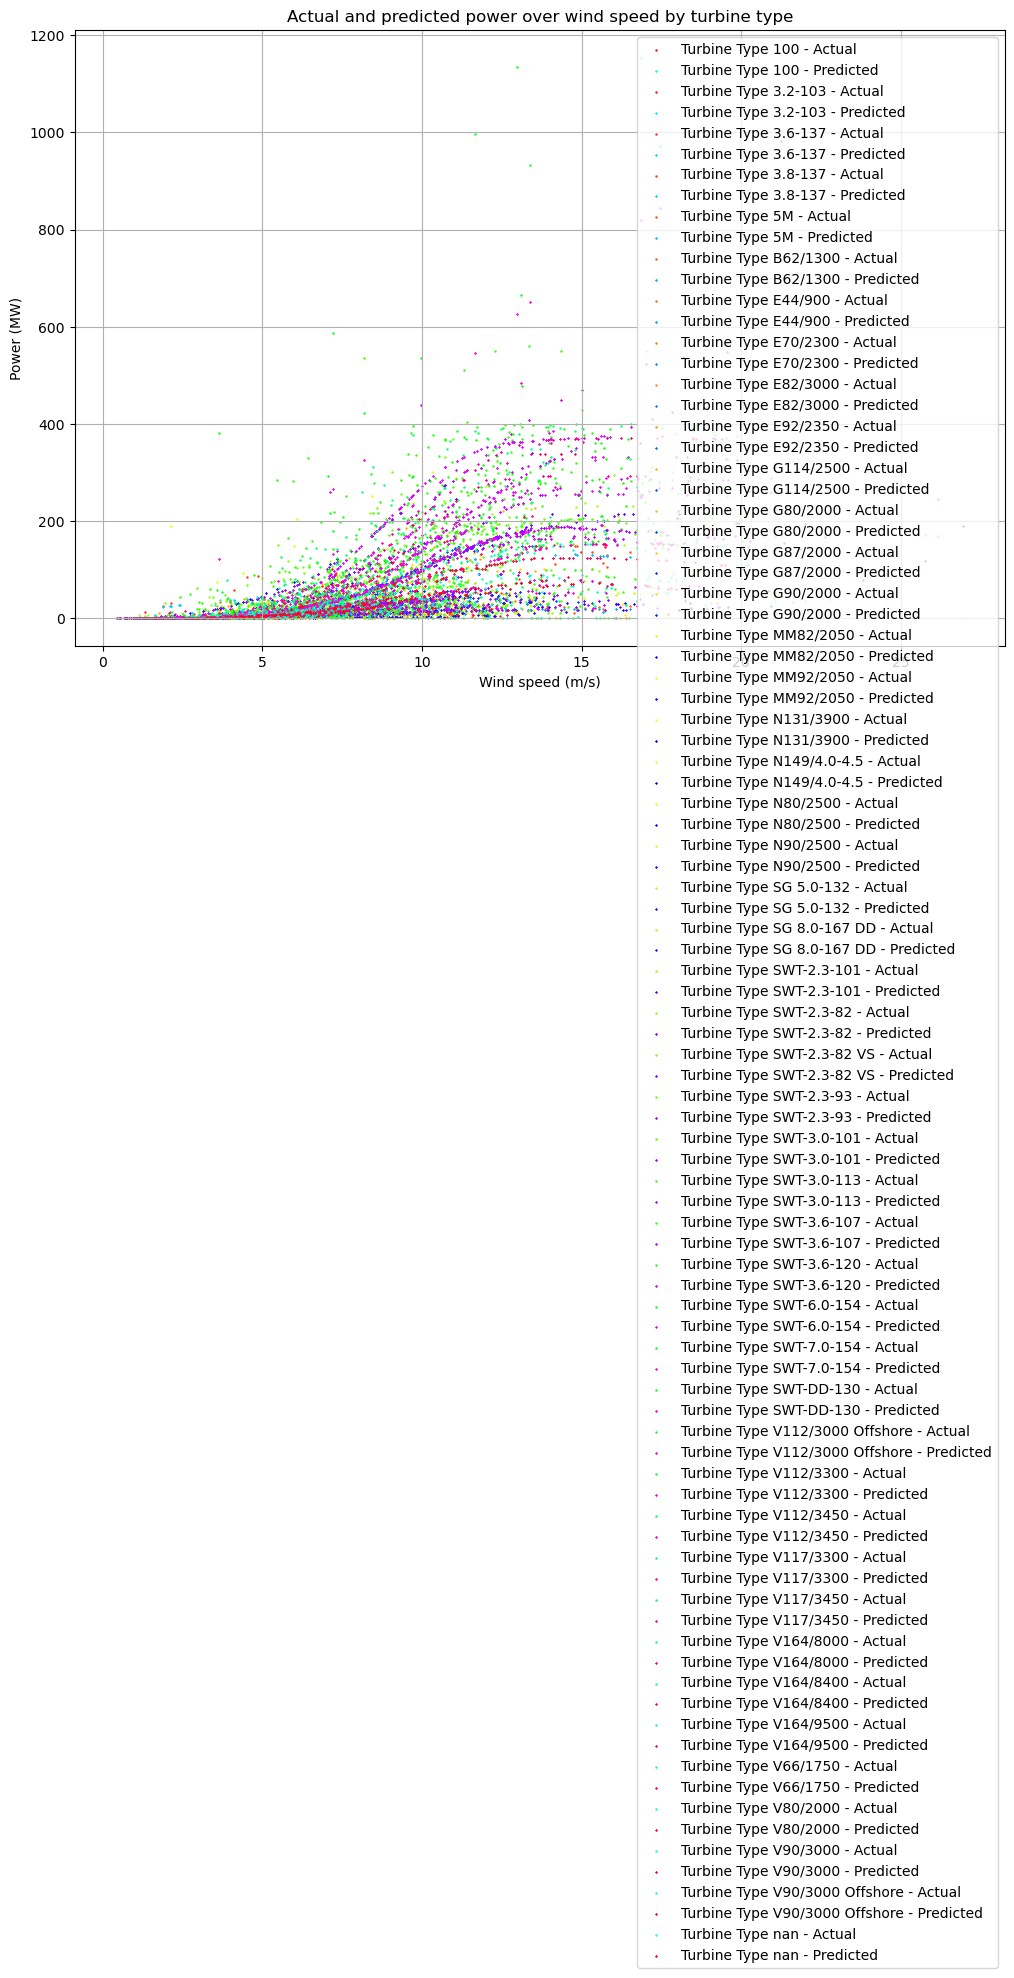

In [7]:
import matplotlib.pyplot as plt

# reconstruct original wind speeds
wind_speeds_validation = scaler_wind.inverse_transform(batch_x_all[:, -1].reshape(-1, 1)).flatten()

# reconstruct original turbine types
turbine_types_validation = np.argmax(batch_x_all[:, 0:-4], axis=1)
turbine_types_validation = encoder.categories_[0][turbine_types_validation]

# Erstellen eines Farbschemas für verschiedene Turbinentypen
unique_turbine_types = np.unique(turbine_types_validation)
colors = plt.cm.get_cmap('hsv', 2*len(unique_turbine_types))

# Erstellen des Scatterplots mit verschiedenen Farben für Turbinentypen
plt.figure(figsize=(12, 8))

# Für jeden Turbinentyp einen Scatter-Plot mit einer anderen Farbe
for i, turbine_type in enumerate(unique_turbine_types):
    mask = turbine_types_validation == turbine_type  # Maske für den jeweiligen Turbinentyp
    plt.scatter(wind_speeds_validation[mask], batch_y_all[mask], s=0.5, color=colors(i), label=f"Turbine Type {turbine_type} - Actual")
    plt.scatter(wind_speeds_validation[mask], val_outputs_all[mask], s=0.5, color=colors(len(unique_turbine_types)+i), marker='x', label=f"Turbine Type {turbine_type} - Predicted")

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted power over wind speed by turbine type')
plt.legend()
plt.grid(True)
plt.show()

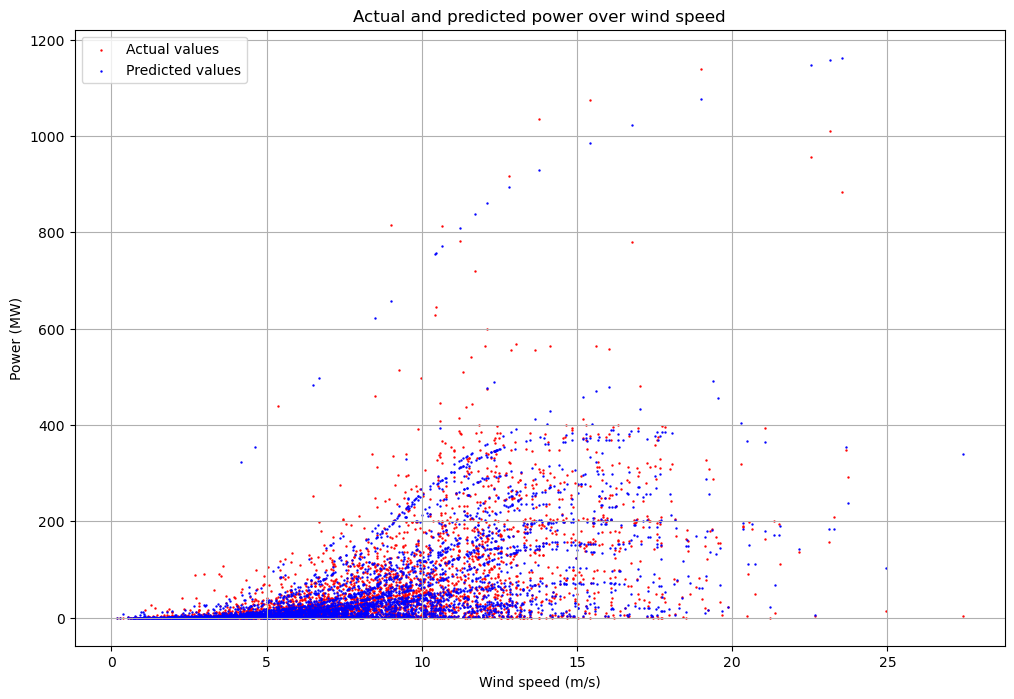

C:\Users\alexa\AppData\Local\Temp\ipykernel_33260\2335326013.py:23: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(wind_speeds_true, (val_outputs_all-batch_y_all) / batch_y_all, color='blue', s=0.5)


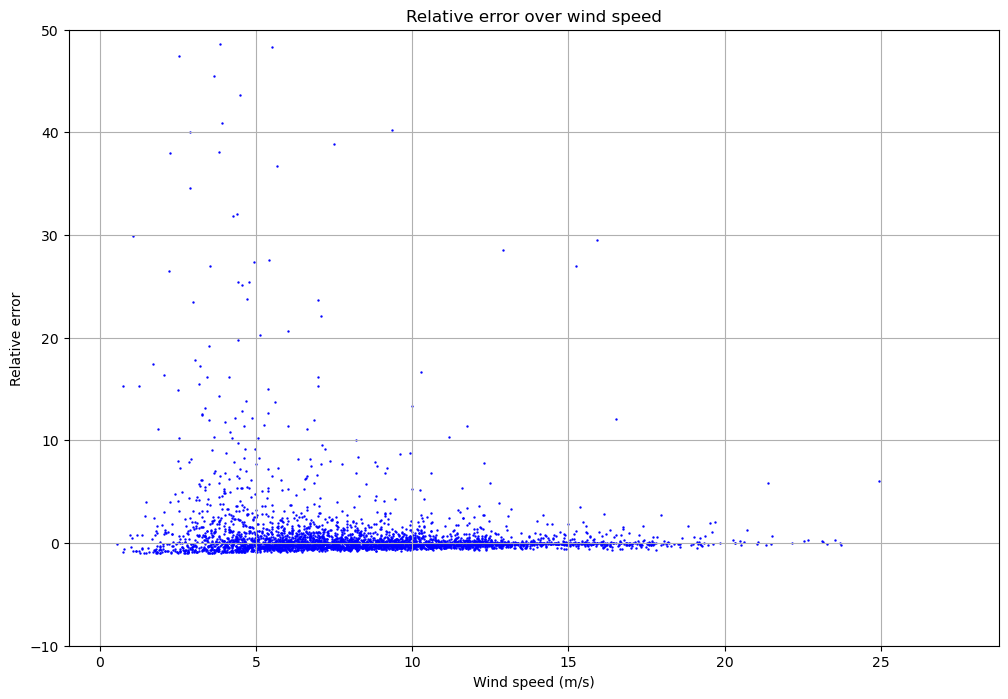

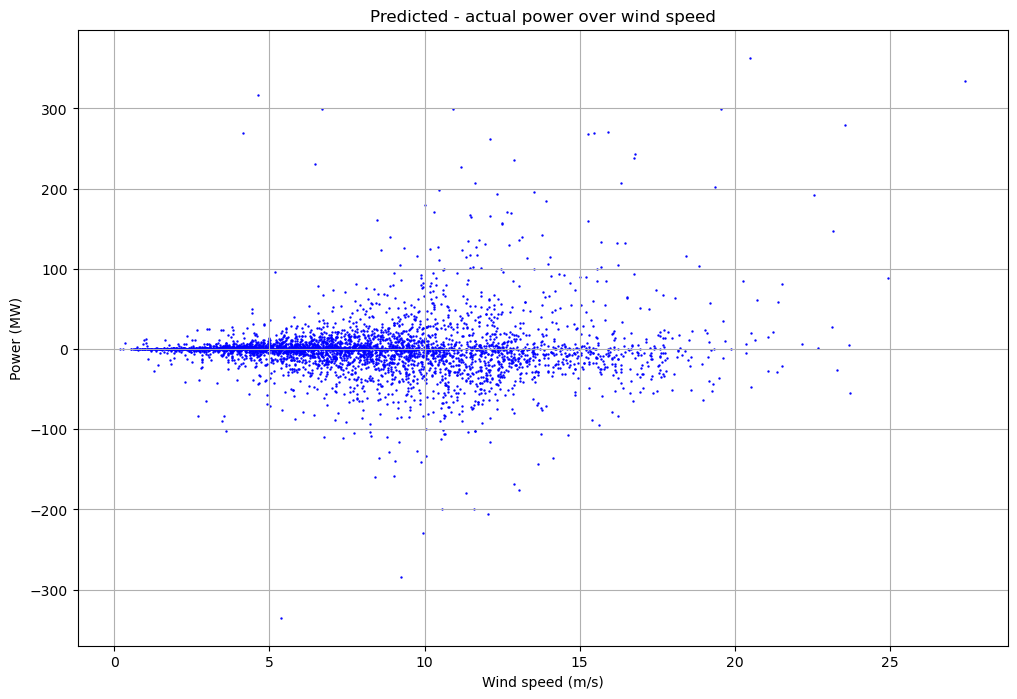

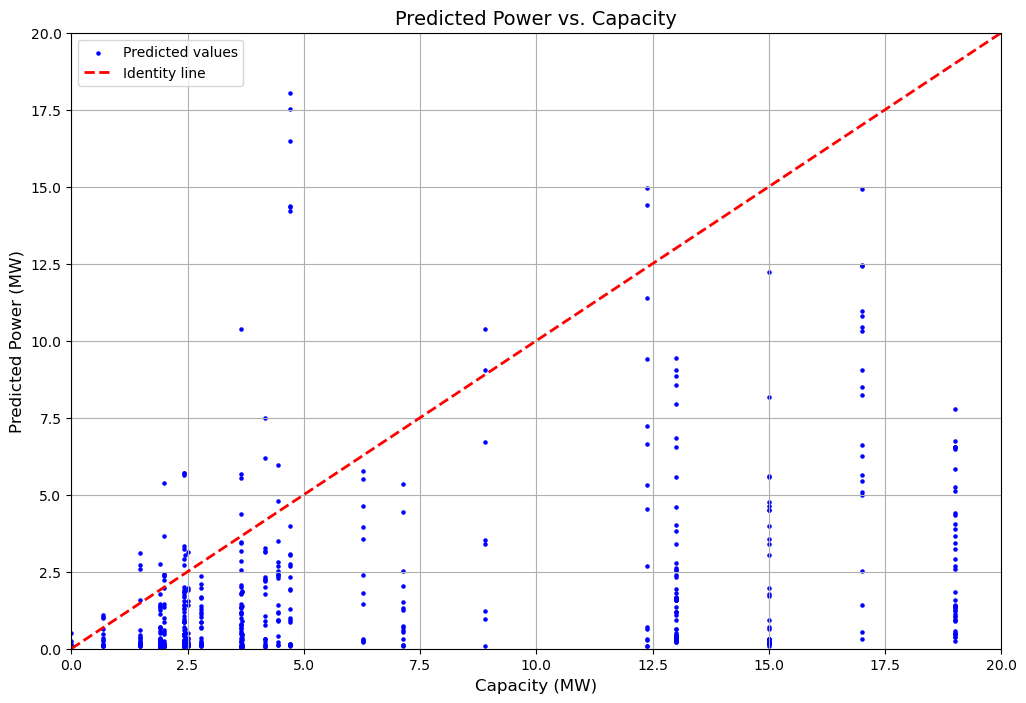

,wind speed,actual values,predicted values
0,4.95,0.220000,0.229889
1,9.45,46.110001,33.237488
2,3.73,4.790000,5.340785
3,6.90,39.500000,20.844925
4,6.34,8.630000,18.430466
...,...,...,...
3995,13.13,7.120000,4.445289
3996,3.55,6.070000,2.160265
3997,8.91,17.540001,17.225952
3998,11.11,187.990005,161.881577


In [119]:
import matplotlib.pyplot as plt

# reconstruct original wind speeds
wind_speeds_true = scaler_wind.inverse_transform(batch_x_all[:, -1].reshape(-1, 1)).flatten()

# reconstruct original turbine types
turbine_types_true = np.argmax(batch_x_all[:, 0:-4], axis=1)
turbine_types_true = encoder.categories_[0][turbine_types_true]

capacities_true = scaler_capacities.inverse_transform(batch_x_all[:, -3].reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_true, batch_y_all, s=0.5, color='red', label="Actual values")
plt.scatter(wind_speeds_true, val_outputs_all, s=0.5, color='blue', label="Predicted values")
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted power over wind speed')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_true, (val_outputs_all-batch_y_all) / batch_y_all, color='blue', s=0.5)
plt.ylim(-10, 50)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Relative error')
plt.title('Relative error over wind speed')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_true, val_outputs_all-batch_y_all, color='blue', s=0.5)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Predicted - actual power over wind speed')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(capacities_true, val_outputs_all.flatten(), s=5, color='blue', label='Predicted values')
min_capacity = min(capacities_true)
max_capacity = max(capacities_true)
plt.plot(
    [min_capacity, max_capacity], 
    [min_capacity, max_capacity], 
    color='red', linestyle='--', linewidth=2, label='Identity line'
)
plt.xlabel('Capacity (MW)', fontsize=12)
plt.ylabel('Predicted Power (MW)', fontsize=12)
plt.title('Predicted Power vs. Capacity', fontsize=14)
plt.grid(True)
plt.legend()
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

# Tabelle erstellen und anzeigen
results_df = pd.DataFrame({
    "wind speed": wind_speeds_true,
    "actual values": batch_y_all.flatten(),
    "predicted values": val_outputs_all.flatten()
})
display(results_df)

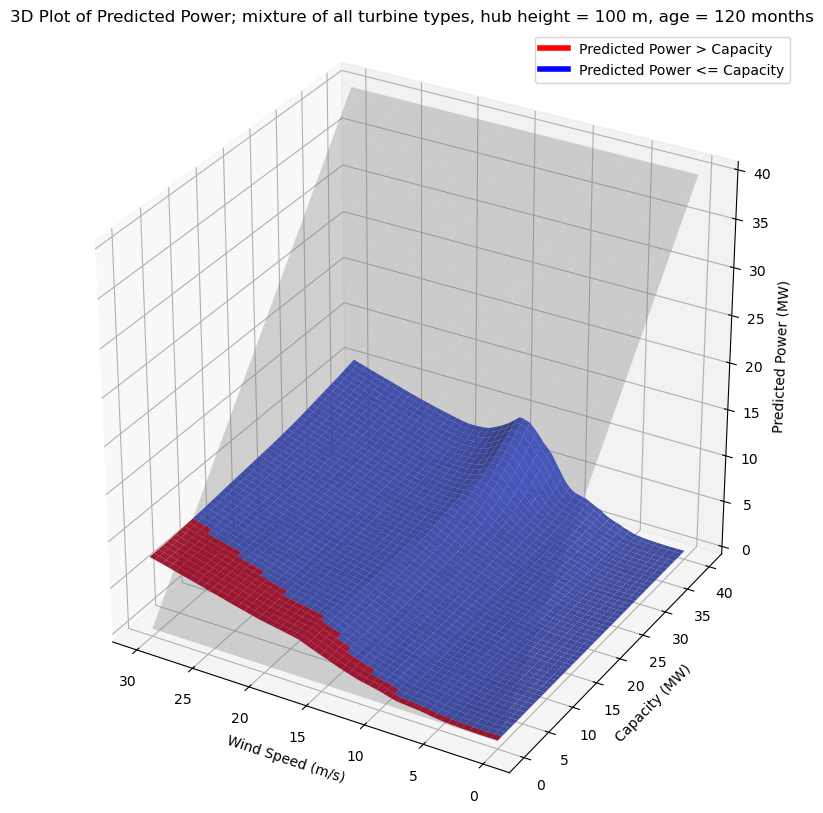

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib

# Laden von Modell und Scaler
metadata = torch.load("model_metadata.pth", weights_only=True)
input_size = metadata["input_size"]
model = MLP(input_size=input_size)
model.load_state_dict(torch.load("trained_model_weights.pth", weights_only=True))
model.eval()

scalers = joblib.load("scalers.pkl")

# Erzeugen von Windgeschwindigkeiten und Kapazitätsbereichen
wind_speeds = np.linspace(0, 30, 250)  # Windgeschwindigkeiten von 0 bis 30 m/s
capacities = np.linspace(0, 40, 250)  # Kapazitäten von 0 bis 40 MW

# Meshgrid erstellen
wind_speeds_grid, capacities_grid = np.meshgrid(wind_speeds, capacities)
wind_speeds_flat = wind_speeds_grid.flatten()
capacities_flat = capacities_grid.flatten()

# Features skalieren
scaled_wind_speeds = scalers["winds"].transform(wind_speeds_flat.reshape(-1, 1)).flatten()
scaled_capacities = scalers["capacities"].transform(capacities_flat.reshape(-1, 1)).flatten()

# Feste Werte für andere Features (Beispiele)
hub_height = 100  # Feste Nabenhöhe
age = 120  # Feste Alter in Monaten
avg_turbine_type = np.ones((len(scaled_wind_speeds), input_size - 4)) / (input_size - 4) # durchschnittliche Turbine: Mischung aus allen Typen
fixed_hub_height = scalers["hub_heights"].transform(np.full((len(scaled_wind_speeds), 1), hub_height)).flatten()  # Feste Nabenhöhe
fixed_age = scalers["ages"].transform(np.full((len(scaled_wind_speeds), 1), age)).flatten()  # Feste Alter in Monaten

# Alle Features kombinieren
all_features = np.hstack([
    avg_turbine_type,
    fixed_hub_height.reshape(-1, 1),
    scaled_capacities.reshape(-1, 1),
    fixed_age.reshape(-1, 1),
    scaled_wind_speeds.reshape(-1, 1)
])

# Vorhersagen machen
input_tensor = torch.tensor(all_features, dtype=torch.float32)
with torch.no_grad():
    predictions = model(input_tensor).numpy().flatten()

# Vorhersagen an Grid anpassen
predictions_grid = predictions.reshape(wind_speeds_grid.shape)

# Flache Ebene: capacity = predicted power
z_flat = capacities_grid  # Die Ebene wird durch capacity = predicted power dargestellt

# 3D-Plot erstellen
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])

# Farben basierend auf Position relativ zur Ebene
color_mask = np.where(predictions_grid > z_flat, 1, 0)  # 1 für oberhalb, 0 für unterhalb
cmap = plt.get_cmap("coolwarm")
norm = plt.Normalize(vmin=0, vmax=1)  # Normierung für die Colormap
facecolors = cmap(norm(color_mask))

# Oberfläche mit Farbmaske plotten
surf = ax.plot_surface(wind_speeds_grid, capacities_grid, predictions_grid, facecolors=facecolors, edgecolor='none', alpha=0.9)

# Flache Ebene hinzufügen
ax.plot_surface(wind_speeds_grid, capacities_grid, z_flat, color='gray', alpha=0.3, edgecolor='none')

ax.set_xlim(ax.get_xlim()[::-1])

# Achsenbeschriftungen und Titel
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Capacity (MW)")
ax.set_zlabel("Predicted Power (MW)")
ax.set_title(f"3D Plot of Predicted Power; mixture of all turbine types, hub height = {hub_height} m, age = {age} months")

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='red', lw=4, label='Predicted Power > Capacity'),
    Line2D([0], [0], color='blue', lw=4, label='Predicted Power <= Capacity')
]

ax.legend(handles=legend_elements, loc='upper right')

plt.show()


In [110]:
import numpy as np
import pandas as pd
import json
from scipy.stats import weibull_min
from sklearn.preprocessing import MinMaxScaler

file_path_json = r"C:\Users\alexa\Documents\Webapp\data\power_curves.json"
with open(file_path_json, 'r', encoding='utf-16') as file:
    # Zeilenweise die Inhalte als Python-Listen parsen
    data_raw = [eval(line.strip()) for line in file]
wind_speeds_extracted = [float(item[0]) for item in data_raw]
powers_extracted = [item[1]/1e3 for item in data_raw] # conversion from kW to MW

# assignment of power curve to turbine type
file_path_excel = r"C:\Users\alexa\Documents\Webapp\data\turbine_data.xlsx"
excel_data = pd.read_excel(file_path_excel, sheet_name='Turbine Types')
power_curve_available = excel_data['The Wind Power'].notna()
turbine_types_with_power_curve = np.array(excel_data['Turbine Types'][power_curve_available])

# Extraction of the power curves
power_curves_individual = []
j = 0
i = 0
while j < len(wind_speeds_extracted):
    if wind_speeds_extracted[j] == 0:
        power_curves_individual.append([[], []])
        i += 1
    power_curves_individual[i-1][0].append(wind_speeds_extracted[j])
    power_curves_individual[i-1][1].append(powers_extracted[j])
    j += 1
    
num_real_data_points = combined_features_raw.shape[0]
num_synthetic_data = num_real_data_points // 10  # 10% der echten Daten
num_per_curve = num_synthetic_data // len(power_curves_individual)

# JSON-Datei für synthetische Daten
synthetic_data = []

# Parameter der Weibull-Verteilung
k = 2.0  # Formparameter
lambda_ = 8.0  # Skalenparameter (entspricht ungefähr der mittleren Windgeschwindigkeit)

# Zielbereich für die Kapazitäten
target_capacity_range = (0, 15)  # Bereich [0, 15 MW], dort fehlen reale Daten
capacity_scaler = MinMaxScaler(feature_range=target_capacity_range)

# Alle Kapazitäten aus den Power Curves extrahieren
max_capacities = [max(powers) for _, powers in power_curves_individual]

# Normalisierung der Kapazitäten in den Zielbereich
scaled_capacities = capacity_scaler.fit_transform(np.array(max_capacities).reshape(-1, 1)).flatten()

# Generiere synthetische Daten
for idx, (wind_speeds, powers) in enumerate(power_curves_individual):
    # Prüfen, ob der Turbinentyp bekannt ist
    turbine_type = turbine_types_with_power_curve[idx]
    if turbine_type not in unique_turbine_types:
        turbine_type = "nan"

    # Skalierte Kapazität für diese Power Curve
    capacity = scaled_capacities[idx]

    for _ in range(num_per_curve):
        # Generiere Windgeschwindigkeit
        wind_speed = weibull_min.rvs(c=k, scale=lambda_, size=1)[0]
        wind_speed = max(0, min(30, wind_speed))  # Begrenze auf [0, 30]

        # Interpoliere die Leistung basierend auf der Power Curve
        power = np.interp(wind_speed, wind_speeds, powers)

        # Skaliere die Produktion proportional zur Kapazität
        production = power * capacity / max(powers)

        # Produktionsdatensatz erstellen
        production_entry = {
            "Turbine": turbine_type,
            "Hub_height": 100,  # Fester Wert
            "Capacity": round(capacity, 2),  # Kapazität (MW)
            "Commissioning_date": "2015/06",  # Fester Wert
            "Production": [[0, round(production, 2), round(wind_speed, 2)]]  # Zeit, Produktion, Windgeschwindigkeit
        }

        synthetic_data.append(production_entry)

unique_turbines = np.unique([entry["Turbine"] for entry in synthetic_data])
print(f"number of unique turbines: {len(unique_turbines)}")

# Speichern der synthetischen Daten in einer JSON-Datei
output_file_path = r"data/synthetic_data.json"
with open(output_file_path, "w", encoding="utf-8") as f:
    json.dump(synthetic_data, f, indent=2, ensure_ascii=False)

print(f"{len(synthetic_data)} synthetische Datenpunkte wurden in {output_file_path} gespeichert.")

number of unique turbines: 36
333792 synthetische Datenpunkte wurden in data/synthetic_data.json gespeichert.


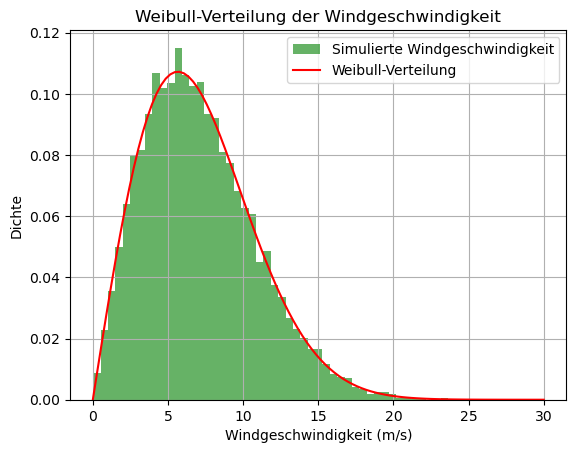

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter der Weibull-Verteilung
k = 2.0  # Formparameter
lambda_ = 8.0  # Skalenparameter

# Simuliere Windgeschwindigkeiten
wind_speeds = np.random.weibull(k, 10000) * lambda_

# Visualisiere die simulierte Verteilung
plt.hist(wind_speeds, bins=50, density=True, alpha=0.6, color='g', label="Simulierte Windgeschwindigkeit")
x = np.linspace(0, 30, 100)
pdf = (k / lambda_) * (x / lambda_)**(k - 1) * np.exp(-(x / lambda_)**k)
plt.plot(x, pdf, 'r-', label="Weibull-Verteilung")
plt.xlabel('Windgeschwindigkeit (m/s)')
plt.ylabel('Dichte')
plt.legend()
plt.grid(True)
plt.title('Weibull-Verteilung der Windgeschwindigkeit')
plt.show()

In [ ]:
capacity_min = min(capacities_true)
mask_min_capacity = capacities_true == capacity_min
features_min_capacity = batch_x_all[mask_min_capacity][:, -4:]
productions_min_capacity = batch_y_all[mask_min_capacity]
predictions_min_capacity = val_outputs_all[mask_min_capacity]

# Tabelle mit Features und Vorhersagen erstellen
columns_features = ["Hub Height (Scaled)", "Capacity (Scaled)", "Age (Scaled)", "Wind Speed (Scaled)"]
features_df = pd.DataFrame(features_min_capacity, columns=columns_features)
features_df["Real Production (MW)"] = productions_min_capacity
features_df["Predicted Production (MW)"] = predictions_min_capacity

# Tabelle anzeigen
from IPython.display import display
display(features_df)

In [23]:
import importlib.util
spec = importlib.util.find_spec("ace_tools")
print(spec)


None


Model loaded
Hub Heights (m): 60.0
Capacities (MW): 0.13000001
Ages (months): 141.0
Wind Speeds (m/s): 8.97
Predictions (MW): [1.7365323  1.3524072  0.25986546 0.1885993  1.1171694  2.3305106
 1.0357773  0.95086557 0.20862484 1.2011304  1.0273119  0.18614434
 1.7049336  2.4900799  0.9850506  1.2011304  1.5395526  1.7905256
 0.34028077 0.18429533 1.0118732  1.0080383  2.2628472  0.22235185
 0.6837703  0.24404848 0.9622609  0.5562196  0.21747534 1.1817298
 1.4756587  1.5620252  1.0003694  0.21424037 1.6568422  1.9634002
 2.001934   0.18718857 2.4818976  2.1678765  1.7974948  3.1117022
 2.5191972  0.43131134 1.4474597  1.8366286  2.8673034  1.5150443
 2.0751188  0.29063493 2.9168274  1.8079487  2.1140301  1.7596055
 0.23539391 0.92823327 1.3014562  0.24404848 4.174406   2.2444844
 0.6640078  0.21747534 0.47614524 2.4580028  1.8511635  1.0042038
 0.19063024 3.065854  ]


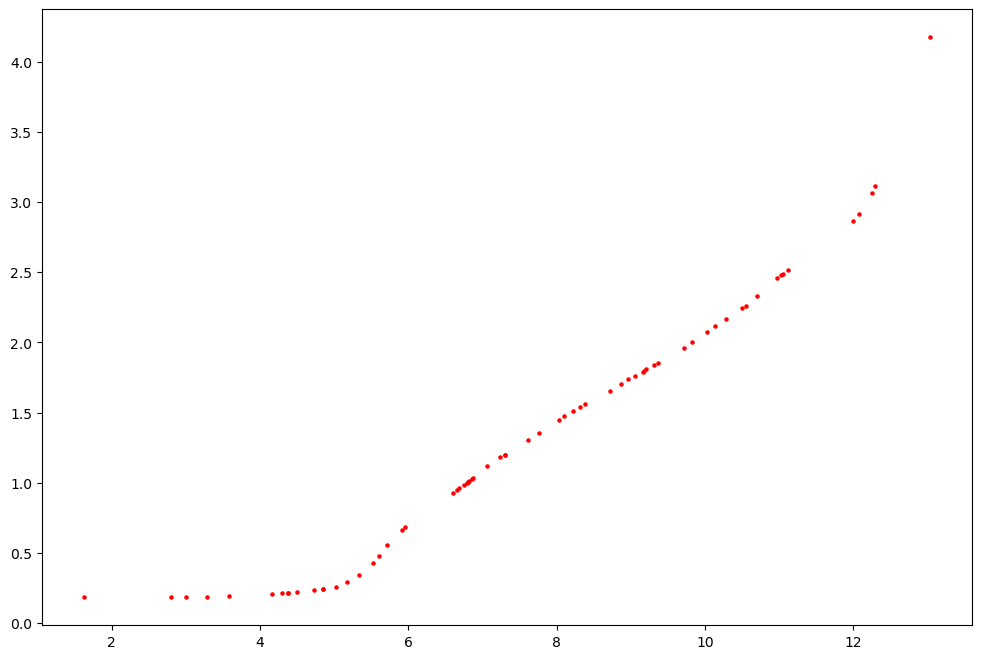

In [50]:
import joblib
import numpy as np
import torch

# Lade die Metadaten
metadata_path = "model_metadata.pth"
metadata = torch.load(metadata_path, weights_only=True)

# Initialisiere das Modell
input_size = metadata["input_size"]
model = MLP(input_size=input_size)

# Lade die Modellgewichte
weights_path = "trained_model_weights.pth"
model.load_state_dict(torch.load(weights_path, weights_only=True))

model.eval()
print("Model loaded")

# # Lade das gespeicherte Features-Array
#features_min_capacity = np.load("all_input_features.npy")

features_min_capacity = batch_x_all[mask_min_capacity]
productions_min_capacity = batch_y_all[mask_min_capacity]
predictions_min_capacity = val_outputs_all[mask_min_capacity]

# Lade die Skalierer
scalers = joblib.load("scalers.pkl")

# Spaltenweise inverse Skalierung
# Angenommen, die Reihenfolge der Spalten ist:
# turbine_type_onehot, scaled_hub_heights, scaled_capacities, scaled_ages_months, scaled_wind_speeds
turbine_types_onehot = features_min_capacity[:, 0:-4]
scaled_hub_heights = features_min_capacity[:, -4]
scaled_capacities = features_min_capacity[:, -3]
scaled_ages_months = features_min_capacity[:, -2]
scaled_wind_speeds = features_min_capacity[:, -1]

# Inverse Transformation
hub_heights = scalers["hub_heights"].inverse_transform(scaled_hub_heights.reshape(-1, 1)).flatten()
capacities = scalers["capacities"].inverse_transform(scaled_capacities.reshape(-1, 1)).flatten()/100
ages_months = scalers["ages"].inverse_transform(scaled_ages_months.reshape(-1, 1)).flatten()
wind_speeds = scalers["winds"].inverse_transform(scaled_wind_speeds.reshape(-1, 1)).flatten()

# Drucke die invers skalierten Werte
print("Hub Heights (m):", hub_heights[0])
print("Capacities (MW):", capacities[0])
print("Ages (months):", ages_months[0])
print("Wind Speeds (m/s):", wind_speeds[0])

scaled_capacities = scalers["capacities"].transform(capacities.reshape(-1, 1)).flatten()

features_min_capacity_tuned = np.hstack((
    turbine_types_onehot,
    scaled_hub_heights.reshape(-1, 1),
    scaled_capacities.reshape(-1, 1),
    scaled_ages_months.reshape(-1, 1),
    scaled_wind_speeds.reshape(-1, 1)
))

# Input Tensor für das Modell
input_tensor = torch.tensor(features_min_capacity_tuned, dtype=torch.float32)

# Vorhersagen
with torch.no_grad():
    predictions = model(input_tensor).numpy().flatten()

print("Predictions (MW):", predictions)

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds, predictions, s=5, color='red', label='Actual values')

In [12]:
loaded_features

array([[ 0.        ,  0.        ,  0.        , ..., -1.18948238,
         3.71625513, -1.01269814],
       [ 0.        ,  0.        ,  0.        , ..., -1.18948238,
         3.71625513, -0.88433865],
       [ 0.        ,  0.        ,  0.        , ..., -1.18948238,
         3.71625513, -0.75597922],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.18948238,
         3.71625513,  1.48606873],
       [ 0.        ,  0.        ,  0.        , ..., -1.18948238,
         3.71625513,  1.44304789],
       [ 0.        ,  0.        ,  0.        , ..., -1.18948238,
         3.71625513,  1.40002692]])

Histograms showing error distribution

In [9]:
import numpy as np

# Fehlerberechnung
absolute_errors = val_outputs_all - batch_y_all
relative_errors = (val_outputs_all - batch_y_all) / (batch_y_all + 1e-8)

# Berechnung von Mittelwert und Standardabweichung
mean_abs_error = np.mean(absolute_errors)
std_abs_error = np.std(absolute_errors)

mean_rel_error = np.mean(relative_errors)
std_rel_error = np.std(relative_errors)

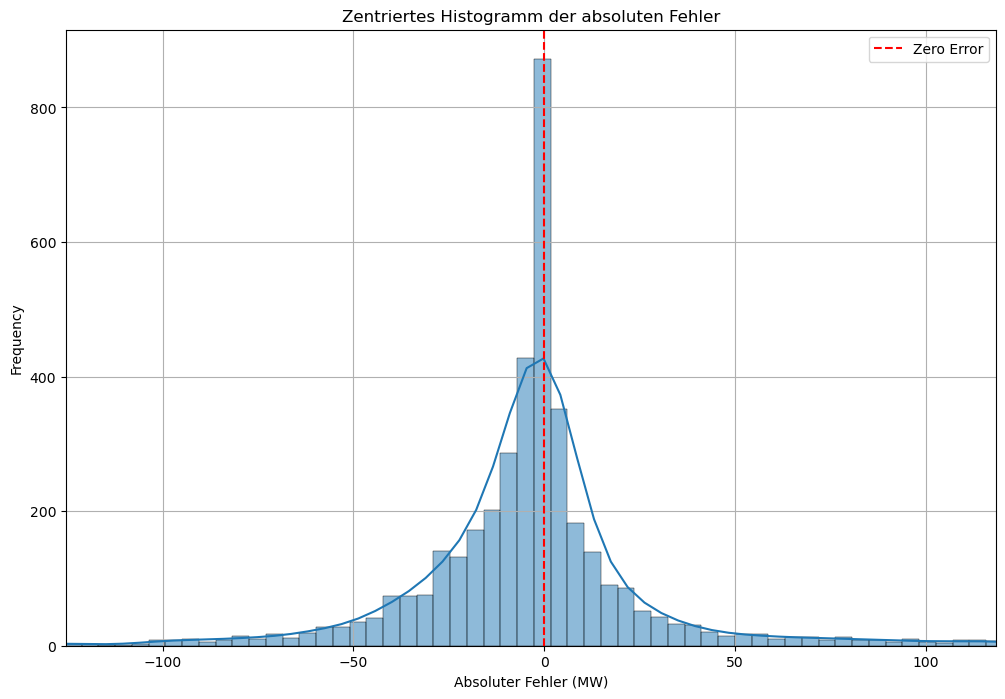

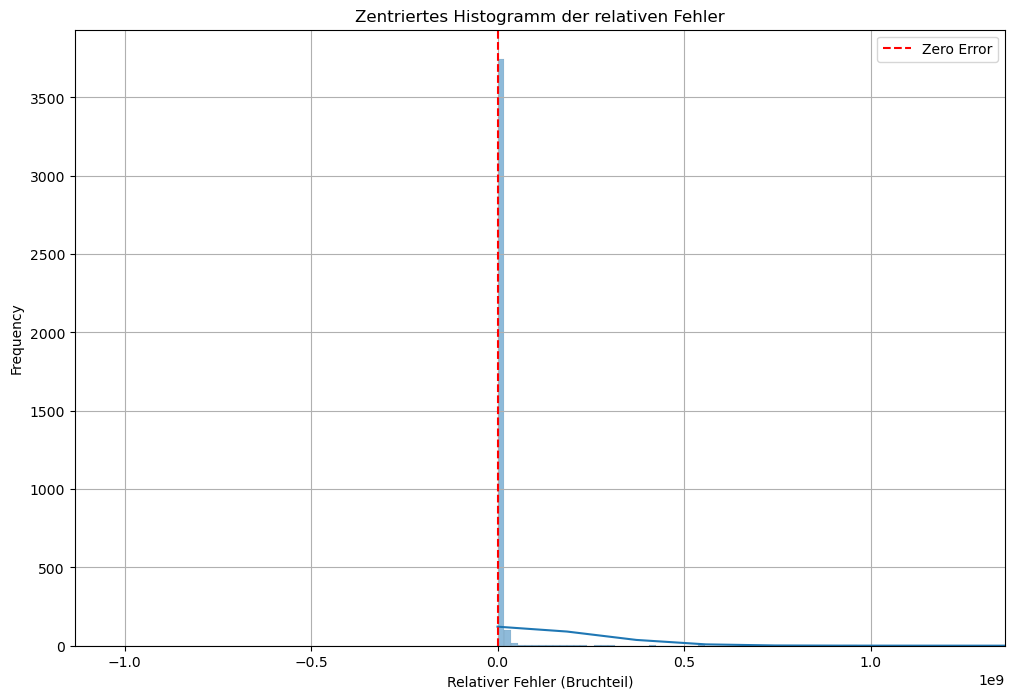

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Absoluter Fehler: Histogramm um 0 zentrieren
plt.figure(figsize=(12, 8))
sns.histplot(absolute_errors, bins=200, kde=True, color='skyblue')
plt.xlim(mean_abs_error - 3*std_abs_error, mean_abs_error + 3*std_abs_error)
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Zentriertes Histogramm der absoluten Fehler")
plt.xlabel("Absoluter Fehler (MW)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

# Relativer Fehler: Histogramm um 0 zentrieren
plt.figure(figsize=(12, 8))
sns.histplot(relative_errors, bins=2000, kde=True, color='orange')
plt.xlim(mean_rel_error - std_rel_error, mean_rel_error + std_rel_error)
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Zentriertes Histogramm der relativen Fehler")
plt.xlabel("Relativer Fehler (Bruchteil)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()


<h1>Evaluate Feature Importance

In [86]:
import numpy as np

# Feature-Namen definieren
feature_names = np.array((
    list(encoder.get_feature_names_out(["Turbine"])) + 
    ["Hub_height", "Capacity", "Age", "Wind_speed"]
))

In [124]:
import numpy as np

# Maske mit zufälligen Indizes erstellen
random_indices = np.random.choice(len(combined_features), size=1000, replace=False)

# Werte aus combined_features basierend auf der Maske auswählen
masked_features = combined_features[random_indices]

model.eval()

1. shapley-values

In [105]:
import torch
import shap

# Eingabe für den SHAP-Explainer vorbereiten
input_tensor = torch.tensor(masked_features, dtype=torch.float32).to(device)

# SHAP-Explainer erstellen
explainer = shap.GradientExplainer(model, input_tensor)

# SHAP-Werte berechnen
shap_values = explainer.shap_values(input_tensor)

# SHAP-Werte umformen
shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

In [ ]:
import shap

shap.summary_plot(shap_values_reshaped, masked_features, feature_names)

In [ ]:
import shap
import torch

shap.initjs()

# Modellvorhersagen auf dem Eingabedatensatz berechnen
base_value = model(torch.tensor(masked_features, dtype=torch.float32).to(device)).mean().item()

shap.plots.force(base_value, shap_values_reshaped, feature_names)

In [ ]:
import shap
import numpy as np

# Base Value in ein Array umwandeln
base_values_array = np.full((shap_values_reshaped.shape[0],), base_value)

# SHAP Explanation-Objekt erstellen
shap_values_explanation = shap.Explanation(
    values=shap_values_reshaped,
    base_values=base_values_array,  # Array statt float
    data=masked_features,  # Eingabedaten
    feature_names=feature_names  # Feature-Namen
)

# Bar-Plot erstellen
shap.plots.bar(shap_values_explanation)

2. gradient method

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Modell in Evaluierungsmodus
model.eval()

# Eingabegröße reduzieren
input_tensor = torch.tensor(masked_features, dtype=torch.float32, requires_grad=True).to(device)

# Vorhersage berechnen
outputs = model(input_tensor)

# Mittleren Output für den Gradienten berechnen
outputs.mean().backward()

# Gradienten extrahieren und sortieren
feature_importance = input_tensor.grad.abs().mean(dim=0).cpu().detach().numpy()

# Nach Wichtigkeit sortieren
sorted_idx = np.argsort(feature_importance)

# Visualisierung
plt.figure(figsize=(10, 8))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Average Gradient Magnitude")
plt.title("Feature Importance using Gradients")
plt.show()

3. Spearman Correlation Coefficient Matrix

In [ ]:
import pandas as pd
import seaborn as sns

num_turbine_type_columns = turbine_types_onehot.shape[1]

# DataFrame ohne Turbinentypen erstellen
df = pd.DataFrame(
    combined_features[:, num_turbine_type_columns:], 
    columns=["Hub Height", "Capacity", "Commissioning Date", "Wind Speed"]
)

# Ausgabe hinzufügen
df['Power'] = output.flatten()

# Spearman-Korrelation berechnen
spearman_corr_matrix = df.corr(method='spearman')

# Farbcodierte Tabelle anzeigen
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Spearman Correlation Heatmap")
plt.show()